In [56]:
import importlib
import utilities  # your module

importlib.reload(utilities)


<module 'utilities' from '/home/jovyan/files/utilities.py'>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from datetime import datetime,timedelta
import requests
import ta
import base64
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from sqlalchemy import text

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
with open(os.getenv("PRIVATE_KEY_PATH"), "rb") as key_file:
    private_key = serialization.load_pem_private_key(
        key_file.read(),
        password=None,
        backend=default_backend()
    )

private_key_pkcs8 = base64.b64encode(
    private_key.private_bytes(
        encoding=serialization.Encoding.DER,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.NoEncryption()
    )
).decode("utf-8")  # ✅ base64 string, not bytes!

engine = create_engine(URL(
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    user=os.getenv("SNOWFLAKE_USER"),
    private_key=private_key_pkcs8,
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
    role=os.getenv("SNOWFLAKE_ROLE")
))

with engine.connect() as conn:
    result = conn.execute(text("SELECT CURRENT_USER(), CURRENT_ROLE(), CURRENT_TIMESTAMP();"))
    for row in result:
        print("✅ Snowflake connected:", row)


✅ Snowflake connected: ('CRYPTO_USER', 'CRYPTO_ROLE', datetime.datetime(2025, 4, 21, 17, 37, 19, 750000, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>))


In [5]:
from datetime import datetime

execution_time = datetime.now().strftime("%Y%m%d%H%M%S")

In [6]:
top100 = pd.read_csv('Assets_Categorized.csv')

In [7]:
top100['staging'] = '@cryptodatasource'
top100.drop(columns=['realticker'],inplace=True)
#if top100['market'] == 'Crypto':
#    top100['ticker'] = top100['ticker']+'-USD'


In [8]:
top100.head()

,name,category,market,ticker,staging
0,Bitcoin,Layer 1,Crypto,BTC-USD,@cryptodatasource
1,Ethereum,Layer 1,Crypto,ETH-USD,@cryptodatasource
2,Tether,Stablecoin,Crypto,USDT-USD,@cryptodatasource
3,XRP,Layer 1,Crypto,XRP-USD,@cryptodatasource
4,BNB,Layer 1,Crypto,BNB-USD,@cryptodatasource


In [9]:
from utilities import download_yahoo_to_stage

now = datetime(datetime.now().year,datetime.now().month,datetime.now().day)
start_date = datetime(2020, 1, 1)

for index, row in top100.iterrows():
    # Safe SQL string formatting using :params
    query = text("SELECT coalesce(dateadd(day,1,MAX(date)),'2019-01-01') as date FROM PUBLIC.VW_CRYPTO WHERE ticker = :ticker ")
     #query = text("SELECT dateadd(day,1,cast(date_trunc('day',MAX(date)) as date)) as date FROM PUBLIC.VW_CRYPTO WHERE ticker = :ticker ")
    df_date = pd.read_sql(query, con=engine, params={"ticker": row['ticker']})
    start_date = pd.to_datetime(df_date['date'].iloc[0])
     
    if start_date > now:
        print(f"✅ {row['ticker']}: Up to date — skipping download.")
    else:
        # Download only what’s missing
        download_yahoo_to_stage(
            ticker=row['ticker'],
            private_key=private_key,
            stage_area=row['staging'],
            interval="1d",
            start=start_date,
            time="12:00 AM",
            execution_time=execution_time
        )


🔍 Downloading data for BTC-USD from Yahoo Finance...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: BTC_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BTC_USD_history_20250422003719.parquet
🧹 Temp file removed: BTC_USD_history_20250422003719.parquet
✅ Upload complete for BTC-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ETH-USD from Yahoo Finance...
✅ Starting upload file process: ETH_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ETH_USD_history_20250422003719.parquet
🧹 Temp file removed: ETH_USD_history_20250422003719.parquet
✅ Upload complete for ETH-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for USDT-USD from Yahoo Finance...
✅ Starting upload file process: USDT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: USDT_USD_history_20250422003719.parquet
🧹 Temp file removed: USDT_USD_history_20250422003719.parquet
✅ Upload complete for USDT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for XRP-USD from Yahoo Finance...
✅ Starting upload file process: XRP_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: XRP_USD_history_20250422003719.parquet
🧹 Temp file removed: XRP_USD_history_20250422003719.parquet
✅ Upload complete for XRP-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BNB-USD from Yahoo Finance...
✅ Starting upload file process: BNB_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BNB_USD_history_20250422003719.parquet
🧹 Temp file removed: BNB_USD_history_20250422003719.parquet
✅ Upload complete for BNB-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for SOL-USD from Yahoo Finance...
✅ Starting upload file process: SOL_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: SOL_USD_history_20250422003719.parquet
🧹 Temp file removed: SOL_USD_history_20250422003719.parquet
✅ Upload complete for SOL-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for USDC-USD from Yahoo Finance...


✅ Starting upload file process: USDC_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: USDC_USD_history_20250422003719.parquet
🧹 Temp file removed: USDC_USD_history_20250422003719.parquet
✅ Upload complete for USDC-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for DOGE-USD from Yahoo Finance...


✅ Starting upload file process: DOGE_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: DOGE_USD_history_20250422003719.parquet
🧹 Temp file removed: DOGE_USD_history_20250422003719.parquet
✅ Upload complete for DOGE-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ADA-USD from Yahoo Finance...
✅ Starting upload file process: ADA_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ADA_USD_history_20250422003719.parquet
🧹 Temp file removed: ADA_USD_history_20250422003719.parquet
✅ Upload complete for ADA-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for TRX-USD from Yahoo Finance...
✅ Starting upload file process: TRX_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: TRX_USD_history_20250422003719.parquet
🧹 Temp file removed: TRX_USD_history_20250422003719.parquet
✅ Upload complete for TRX-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for LEO-USD from Yahoo Finance...
✅ Starting upload file process: LEO_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: LEO_USD_history_20250422003719.parquet
🧹 Temp file removed: LEO_USD_history_20250422003719.parquet
✅ Upload complete for LEO-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for LINK-USD from Yahoo Finance...


✅ Starting upload file process: LINK_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: LINK_USD_history_20250422003719.parquet
🧹 Temp file removed: LINK_USD_history_20250422003719.parquet
✅ Upload complete for LINK-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for TON-USD from Yahoo Finance...
✅ Starting upload file process: TON_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: TON_USD_history_20250422003719.parquet
🧹 Temp file removed: TON_USD_history_20250422003719.parquet
✅ Upload complete for TON-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for XLM-USD from Yahoo Finance...
✅ Starting upload file process: XLM_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: XLM_USD_history_20250422003719.parquet
🧹 Temp file removed: XLM_USD_history_20250422003719.parquet
✅ Upload complete for XLM-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for AVAX-USD from Yahoo Finance...
✅ Starting upload file process: AVAX_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: AVAX_USD_history_20250422003719.parquet
🧹 Temp file removed: AVAX_USD_history_20250422003719.parquet
✅ Upload complete for AVAX-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for SUI-USD from Yahoo Finance...
✅ Starting upload file process: SUI_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: SUI_USD_history_20250422003719.parquet
🧹 Temp file removed: SUI_USD_history_20250422003719.parquet
✅ Upload complete for SUI-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for SHIB-USD from Yahoo Finance...
✅ Starting upload file process: SHIB_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: SHIB_USD_history_20250422003719.parquet
🧹 Temp file removed: SHIB_USD_history_20250422003719.parquet
✅ Upload complete for SHIB-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for HBAR-USD from Yahoo Finance...
✅ Starting upload file process: HBAR_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: HBAR_USD_history_20250422003719.parquet
🧹 Temp file removed: HBAR_USD_history_20250422003719.parquet
✅ Upload complete for HBAR-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for LTC-USD from Yahoo Finance...
✅ Starting upload file process: LTC_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: LTC_USD_history_20250422003719.parquet
🧹 Temp file removed: LTC_USD_history_20250422003719.parquet
✅ Upload complete for LTC-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for DOT-USD from Yahoo Finance...
✅ Starting upload file process: DOT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: DOT_USD_history_20250422003719.parquet
🧹 Temp file removed: DOT_USD_history_20250422003719.parquet
✅ Upload complete for DOT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for OM-USD from Yahoo Finance...
✅ Starting upload file process: OM_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: OM_USD_history_20250422003719.parquet
🧹 Temp file removed: OM_USD_history_20250422003719.parquet
✅ Upload complete for OM-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BCH-USD from Yahoo Finance...
✅ Starting upload file process: BCH_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BCH_USD_history_20250422003719.parquet
🧹 Temp file removed: BCH_USD_history_20250422003719.parquet
✅ Upload complete for BCH-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BGB-USD from Yahoo Finance...
✅ Starting upload file process: BGB_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BGB_USD_history_20250422003719.parquet
🧹 Temp file removed: BGB_USD_history_20250422003719.parquet
✅ Upload complete for BGB-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for DAI-USD from Yahoo Finance...
✅ Starting upload file process: DAI_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: DAI_USD_history_20250422003719.parquet
🧹 Temp file removed: DAI_USD_history_20250422003719.parquet
✅ Upload complete for DAI-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for USDe-USD from Yahoo Finance...
✅ Starting upload file process: USDe_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: USDe_USD_history_20250422003719.parquet
🧹 Temp file removed: USDe_USD_history_20250422003719.parquet
✅ Upload complete for USDe-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for HYPE-USD from Yahoo Finance...
✅ Starting upload file process: HYPE_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: HYPE_USD_history_20250422003719.parquet
🧹 Temp file removed: HYPE_USD_history_20250422003719.parquet
✅ Upload complete for HYPE-USD → @cryptodatasource
🔍 Downloading data for XMR-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: XMR_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: XMR_USD_history_20250422003719.parquet
🧹 Temp file removed: XMR_USD_history_20250422003719.parquet
✅ Upload complete for XMR-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for UNI-USD from Yahoo Finance...
✅ Starting upload file process: UNI_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: UNI_USD_history_20250422003719.parquet
🧹 Temp file removed: UNI_USD_history_20250422003719.parquet
✅ Upload complete for UNI-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for PI-USD from Yahoo Finance...


✅ Starting upload file process: PI_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: PI_USD_history_20250422003719.parquet
🧹 Temp file removed: PI_USD_history_20250422003719.parquet
✅ Upload complete for PI-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for PEPE-USD from Yahoo Finance...
✅ Starting upload file process: PEPE_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: PEPE_USD_history_20250422003719.parquet
🧹 Temp file removed: PEPE_USD_history_20250422003719.parquet
✅ Upload complete for PEPE-USD → @cryptodatasource
🔍 Downloading data for NEAR-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: NEAR_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: NEAR_USD_history_20250422003719.parquet
🧹 Temp file removed: NEAR_USD_history_20250422003719.parquet
✅ Upload complete for NEAR-USD → @cryptodatasource
🔍 Downloading data for APT-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: APT_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: APT_USD_history_20250422003719.parquet
🧹 Temp file removed: APT_USD_history_20250422003719.parquet
✅ Upload complete for APT-USD → @cryptodatasource
🔍 Downloading data for OKB-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: OKB_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: OKB_USD_history_20250422003719.parquet
🧹 Temp file removed: OKB_USD_history_20250422003719.parquet
✅ Upload complete for OKB-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ONDO-USD from Yahoo Finance...
✅ Starting upload file process: ONDO_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ONDO_USD_history_20250422003719.parquet
🧹 Temp file removed: ONDO_USD_history_20250422003719.parquet
✅ Upload complete for ONDO-USD → @cryptodatasource
🔍 Downloading data for CRO-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: CRO_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: CRO_USD_history_20250422003719.parquet
🧹 Temp file removed: CRO_USD_history_20250422003719.parquet
✅ Upload complete for CRO-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for MNT-USD from Yahoo Finance...
✅ Starting upload file process: MNT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: MNT_USD_history_20250422003719.parquet
🧹 Temp file removed: MNT_USD_history_20250422003719.parquet
✅ Upload complete for MNT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ETC-USD from Yahoo Finance...
✅ Starting upload file process: ETC_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ETC_USD_history_20250422003719.parquet
🧹 Temp file removed: ETC_USD_history_20250422003719.parquet
✅ Upload complete for ETC-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ICP-USD from Yahoo Finance...
✅ Starting upload file process: ICP_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ICP_USD_history_20250422003719.parquet
🧹 Temp file removed: ICP_USD_history_20250422003719.parquet
✅ Upload complete for ICP-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for AAVE-USD from Yahoo Finance...
✅ Starting upload file process: AAVE_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: AAVE_USD_history_20250422003719.parquet
🧹 Temp file removed: AAVE_USD_history_20250422003719.parquet
✅ Upload complete for AAVE-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for FDUSD-USD from Yahoo Finance...
✅ Starting upload file process: FDUSD_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FDUSD_USD_history_20250422003719.parquet
🧹 Temp file removed: FDUSD_USD_history_20250422003719.parquet
✅ Upload complete for FDUSD-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for POL-USD from Yahoo Finance...
✅ Starting upload file process: POL_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: POL_USD_history_20250422003719.parquet
🧹 Temp file removed: POL_USD_history_20250422003719.parquet
✅ Upload complete for POL-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ATOM-USD from Yahoo Finance...
✅ Starting upload file process: ATOM_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ATOM_USD_history_20250422003719.parquet
🧹 Temp file removed: ATOM_USD_history_20250422003719.parquet
✅ Upload complete for ATOM-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for GT-USD from Yahoo Finance...
✅ Starting upload file process: GT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: GT_USD_history_20250422003719.parquet
🧹 Temp file removed: GT_USD_history_20250422003719.parquet
✅ Upload complete for GT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for VET-USD from Yahoo Finance...


✅ Starting upload file process: VET_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: VET_USD_history_20250422003719.parquet
🧹 Temp file removed: VET_USD_history_20250422003719.parquet
✅ Upload complete for VET-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for TRUMP-USD from Yahoo Finance...


✅ Starting upload file process: TRUMP_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: TRUMP_USD_history_20250422003719.parquet
🧹 Temp file removed: TRUMP_USD_history_20250422003719.parquet
✅ Upload complete for TRUMP-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for FIL-USD from Yahoo Finance...
✅ Starting upload file process: FIL_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FIL_USD_history_20250422003719.parquet
🧹 Temp file removed: FIL_USD_history_20250422003719.parquet
✅ Upload complete for FIL-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for KAS-USD from Yahoo Finance...
✅ Starting upload file process: KAS_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: KAS_USD_history_20250422003719.parquet
🧹 Temp file removed: KAS_USD_history_20250422003719.parquet
✅ Upload complete for KAS-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ENA-USD from Yahoo Finance...
✅ Starting upload file process: ENA_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ENA_USD_history_20250422003719.parquet
🧹 Temp file removed: ENA_USD_history_20250422003719.parquet
✅ Upload complete for ENA-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for RENDER-USD from Yahoo Finance...
✅ Starting upload file process: RENDER_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: RENDER_USD_history_20250422003719.parquet
🧹 Temp file removed: RENDER_USD_history_20250422003719.parquet
✅ Upload complete for RENDER-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for TIA-USD from Yahoo Finance...
✅ Starting upload file process: TIA_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: TIA_USD_history_20250422003719.parquet
🧹 Temp file removed: TIA_USD_history_20250422003719.parquet
✅ Upload complete for TIA-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ALGO-USD from Yahoo Finance...
✅ Starting upload file process: ALGO_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ALGO_USD_history_20250422003719.parquet
🧹 Temp file removed: ALGO_USD_history_20250422003719.parquet
✅ Upload complete for ALGO-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ARB-USD from Yahoo Finance...
✅ Starting upload file process: ARB_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ARB_USD_history_20250422003719.parquet
🧹 Temp file removed: ARB_USD_history_20250422003719.parquet
✅ Upload complete for ARB-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for S-USD from Yahoo Finance...
✅ Starting upload file process: S_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: S_USD_history_20250422003719.parquet
🧹 Temp file removed: S_USD_history_20250422003719.parquet
✅ Upload complete for S-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for KCS-USD from Yahoo Finance...
✅ Starting upload file process: KCS_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: KCS_USD_history_20250422003719.parquet
🧹 Temp file removed: KCS_USD_history_20250422003719.parquet
✅ Upload complete for KCS-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for DEXE-USD from Yahoo Finance...
✅ Starting upload file process: DEXE_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: DEXE_USD_history_20250422003719.parquet
🧹 Temp file removed: DEXE_USD_history_20250422003719.parquet
✅ Upload complete for DEXE-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for EOS-USD from Yahoo Finance...
✅ Starting upload file process: EOS_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: EOS_USD_history_20250422003719.parquet
🧹 Temp file removed: EOS_USD_history_20250422003719.parquet
✅ Upload complete for EOS-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for OP-USD from Yahoo Finance...
✅ Starting upload file process: OP_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: OP_USD_history_20250422003719.parquet
🧹 Temp file removed: OP_USD_history_20250422003719.parquet
✅ Upload complete for OP-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for JUP-USD from Yahoo Finance...


✅ Starting upload file process: JUP_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: JUP_USD_history_20250422003719.parquet
🧹 Temp file removed: JUP_USD_history_20250422003719.parquet
✅ Upload complete for JUP-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for MKR-USD from Yahoo Finance...


✅ Starting upload file process: MKR_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: MKR_USD_history_20250422003719.parquet
🧹 Temp file removed: MKR_USD_history_20250422003719.parquet
✅ Upload complete for MKR-USD → @cryptodatasource
🔍 Downloading data for XDC-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: XDC_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: XDC_USD_history_20250422003719.parquet
🧹 Temp file removed: XDC_USD_history_20250422003719.parquet
✅ Upload complete for XDC-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for IP-USD from Yahoo Finance...
✅ Starting upload file process: IP_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: IP_USD_history_20250422003719.parquet
🧹 Temp file removed: IP_USD_history_20250422003719.parquet
✅ Upload complete for IP-USD → @cryptodatasource
🔍 Downloading data for FET-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: FET_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FET_USD_history_20250422003719.parquet
🧹 Temp file removed: FET_USD_history_20250422003719.parquet
✅ Upload complete for FET-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for WLD-USD from Yahoo Finance...
✅ Starting upload file process: WLD_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: WLD_USD_history_20250422003719.parquet
🧹 Temp file removed: WLD_USD_history_20250422003719.parquet
✅ Upload complete for WLD-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for MOVE-USD from Yahoo Finance...
✅ Starting upload file process: MOVE_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: MOVE_USD_history_20250422003719.parquet
🧹 Temp file removed: MOVE_USD_history_20250422003719.parquet
✅ Upload complete for MOVE-USD → @cryptodatasource
🔍 Downloading data for STX-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: STX_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: STX_USD_history_20250422003719.parquet
🧹 Temp file removed: STX_USD_history_20250422003719.parquet
✅ Upload complete for STX-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BONK-USD from Yahoo Finance...
✅ Starting upload file process: BONK_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BONK_USD_history_20250422003719.parquet
🧹 Temp file removed: BONK_USD_history_20250422003719.parquet
✅ Upload complete for BONK-USD → @cryptodatasource
🔍 Downloading data for INJ-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: INJ_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: INJ_USD_history_20250422003719.parquet
🧹 Temp file removed: INJ_USD_history_20250422003719.parquet
✅ Upload complete for INJ-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for FORM-USD from Yahoo Finance...
✅ Starting upload file process: FORM_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FORM_USD_history_20250422003719.parquet
🧹 Temp file removed: FORM_USD_history_20250422003719.parquet
✅ Upload complete for FORM-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for QNT-USD from Yahoo Finance...
✅ Starting upload file process: QNT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: QNT_USD_history_20250422003719.parquet
🧹 Temp file removed: QNT_USD_history_20250422003719.parquet
✅ Upload complete for QNT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for FLR-USD from Yahoo Finance...
✅ Starting upload file process: FLR_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FLR_USD_history_20250422003719.parquet
🧹 Temp file removed: FLR_USD_history_20250422003719.parquet
✅ Upload complete for FLR-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for GRT-USD from Yahoo Finance...
✅ Starting upload file process: GRT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: GRT_USD_history_20250422003719.parquet
🧹 Temp file removed: GRT_USD_history_20250422003719.parquet
✅ Upload complete for GRT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for SEI-USD from Yahoo Finance...
✅ Starting upload file process: SEI_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: SEI_USD_history_20250422003719.parquet
🧹 Temp file removed: SEI_USD_history_20250422003719.parquet
✅ Upload complete for SEI-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for IMX-USD from Yahoo Finance...
✅ Starting upload file process: IMX_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: IMX_USD_history_20250422003719.parquet
🧹 Temp file removed: IMX_USD_history_20250422003719.parquet
✅ Upload complete for IMX-USD → @cryptodatasource
🔍 Downloading data for THETA-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: THETA_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: THETA_USD_history_20250422003719.parquet
🧹 Temp file removed: THETA_USD_history_20250422003719.parquet
✅ Upload complete for THETA-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for LDO-USD from Yahoo Finance...
✅ Starting upload file process: LDO_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: LDO_USD_history_20250422003719.parquet
🧹 Temp file removed: LDO_USD_history_20250422003719.parquet
✅ Upload complete for LDO-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for XAUt-USD from Yahoo Finance...
✅ Starting upload file process: XAUt_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: XAUt_USD_history_20250422003719.parquet
🧹 Temp file removed: XAUt_USD_history_20250422003719.parquet
✅ Upload complete for XAUt-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for PYUSD-USD from Yahoo Finance...
✅ Starting upload file process: PYUSD_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: PYUSD_USD_history_20250422003719.parquet
🧹 Temp file removed: PYUSD_USD_history_20250422003719.parquet
✅ Upload complete for PYUSD-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for NEXO-USD from Yahoo Finance...
✅ Starting upload file process: NEXO_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: NEXO_USD_history_20250422003719.parquet
🧹 Temp file removed: NEXO_USD_history_20250422003719.parquet
✅ Upload complete for NEXO-USD → @cryptodatasource
🔍 Downloading data for XTZ-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: XTZ_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: XTZ_USD_history_20250422003719.parquet
🧹 Temp file removed: XTZ_USD_history_20250422003719.parquet
✅ Upload complete for XTZ-USD → @cryptodatasource
🔍 Downloading data for PAXG-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: PAXG_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: PAXG_USD_history_20250422003719.parquet
🧹 Temp file removed: PAXG_USD_history_20250422003719.parquet
✅ Upload complete for PAXG-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for KAIA-USD from Yahoo Finance...
✅ Starting upload file process: KAIA_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: KAIA_USD_history_20250422003719.parquet
🧹 Temp file removed: KAIA_USD_history_20250422003719.parquet
✅ Upload complete for KAIA-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for GALA-USD from Yahoo Finance...
✅ Starting upload file process: GALA_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: GALA_USD_history_20250422003719.parquet
🧹 Temp file removed: GALA_USD_history_20250422003719.parquet
✅ Upload complete for GALA-USD → @cryptodatasource
🔍 Downloading data for SAND-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: SAND_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: SAND_USD_history_20250422003719.parquet
🧹 Temp file removed: SAND_USD_history_20250422003719.parquet
✅ Upload complete for SAND-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for CRV-USD from Yahoo Finance...
✅ Starting upload file process: CRV_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: CRV_USD_history_20250422003719.parquet
🧹 Temp file removed: CRV_USD_history_20250422003719.parquet
✅ Upload complete for CRV-USD → @cryptodatasource
🔍 Downloading data for ZEC-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: ZEC_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: ZEC_USD_history_20250422003719.parquet
🧹 Temp file removed: ZEC_USD_history_20250422003719.parquet
✅ Upload complete for ZEC-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BERA-USD from Yahoo Finance...
✅ Starting upload file process: BERA_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BERA_USD_history_20250422003719.parquet
🧹 Temp file removed: BERA_USD_history_20250422003719.parquet
✅ Upload complete for BERA-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BTT-USD from Yahoo Finance...
✅ Starting upload file process: BTT_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BTT_USD_history_20250422003719.parquet
🧹 Temp file removed: BTT_USD_history_20250422003719.parquet
✅ Upload complete for BTT-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for IOTA-USD from Yahoo Finance...


✅ Starting upload file process: IOTA_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: IOTA_USD_history_20250422003719.parquet
🧹 Temp file removed: IOTA_USD_history_20250422003719.parquet
✅ Upload complete for IOTA-USD → @cryptodatasource
🔍 Downloading data for BSV-USD from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: BSV_USD_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BSV_USD_history_20250422003719.parquet
🧹 Temp file removed: BSV_USD_history_20250422003719.parquet
✅ Upload complete for BSV-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for FLOW-USD from Yahoo Finance...
✅ Starting upload file process: FLOW_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FLOW_USD_history_20250422003719.parquet
🧹 Temp file removed: FLOW_USD_history_20250422003719.parquet
✅ Upload complete for FLOW-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for JTO-USD from Yahoo Finance...
✅ Starting upload file process: JTO_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: JTO_USD_history_20250422003719.parquet
🧹 Temp file removed: JTO_USD_history_20250422003719.parquet
✅ Upload complete for JTO-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for FLOKI-USD from Yahoo Finance...
✅ Starting upload file process: FLOKI_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: FLOKI_USD_history_20250422003719.parquet
🧹 Temp file removed: FLOKI_USD_history_20250422003719.parquet
✅ Upload complete for FLOKI-USD → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for RAY-USD from Yahoo Finance...
✅ Starting upload file process: RAY_USD_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: RAY_USD_history_20250422003719.parquet
🧹 Temp file removed: RAY_USD_history_20250422003719.parquet
✅ Upload complete for RAY-USD → @cryptodatasource
🔍 Downloading data for ^VIX from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: VIX_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: VIX_history_20250422003719.parquet
🧹 Temp file removed: VIX_history_20250422003719.parquet
✅ Upload complete for ^VIX → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for ^NDX from Yahoo Finance...
✅ Starting upload file process: NDX_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: NDX_history_20250422003719.parquet
🧹 Temp file removed: NDX_history_20250422003719.parquet
✅ Upload complete for ^NDX → @cryptodatasource
🔍 Downloading data for ^GSPC from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


✅ Starting upload file process: GSPC_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: GSPC_history_20250422003719.parquet
🧹 Temp file removed: GSPC_history_20250422003719.parquet
✅ Upload complete for ^GSPC → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for GC=F from Yahoo Finance...
✅ Starting upload file process: GC=F_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: GC=F_history_20250422003719.parquet
🧹 Temp file removed: GC=F_history_20250422003719.parquet
✅ Upload complete for GC=F → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for SI=F from Yahoo Finance...
✅ Starting upload file process: SI=F_history_20250422003719.parquet → @cryptodatasource


✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: SI=F_history_20250422003719.parquet
🧹 Temp file removed: SI=F_history_20250422003719.parquet
✅ Upload complete for SI=F → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BTC-INR from Yahoo Finance...
🌐 Downloading FX rate: INR=X for conversion to USD...



[*********************100%***********************]  1 of 1 completed


💱 Converted BTC-INR OHLC data to USD using INR=X
✅ Starting upload file process: BTC_INR_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BTC_INR_history_20250422003719.parquet
🧹 Temp file removed: BTC_INR_history_20250422003719.parquet
✅ Upload complete for BTC-INR → @cryptodatasource
🔍 Downloading data for BTC-VND from Yahoo Finance...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BTC-VND?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BTC-VND&crumb=mI0yNU879V2
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-VND']: AttributeError("'NoneType' object has no attribute 'update'")


⚠️ No data returned for BTC-VND from Yahoo Finance.
🔄 Trying CoinMarketCap for BTC-VND...
📥 Fetching BTC-VND from CoinGecko (2303 days)...
⚠️ Error fetching CoinGecko data: {"status":{"timestamp":"2025-04-22T00:40:40.855+00:00","error_code":10005,"error_message":"Invalid value for 'interval'"}}
⛔ Still no data. Skipping BTC-VND
🔍 Downloading data for BTC-PKR from Yahoo Finance...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BTC-PKR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BTC-PKR&crumb=mI0yNU879V2
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-PKR']: AttributeError("'NoneType' object has no attribute 'update'")


⚠️ No data returned for BTC-PKR from Yahoo Finance.
🔄 Trying CoinMarketCap for BTC-PKR...
📥 Fetching BTC-PKR from CoinGecko (2303 days)...
⚠️ Error fetching CoinGecko data: {"status":{"timestamp":"2025-04-22T00:40:43.756+00:00","error_code":10005,"error_message":"Invalid value for 'interval'"}}
⛔ Still no data. Skipping BTC-PKR
🔍 Downloading data for BTC-BRL from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-BRL']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data returned for BTC-BRL from Yahoo Finance.
🔄 Trying CoinMarketCap for BTC-BRL...
📥 Fetching BTC-BRL from CoinGecko (2303 days)...
⚠️ Error fetching CoinGecko data: {"status":{"timestamp":"2025-04-22T00:40:46.028+00:00","error_code":10005,"error_message":"Invalid value for 'interval'"}}
⛔ Still no data. Skipping BTC-BRL
🔍 Downloading data for BTC-THB from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-THB']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data returned for BTC-THB from Yahoo Finance.
🔄 Trying CoinMarketCap for BTC-THB...
📥 Fetching BTC-THB from CoinGecko (2303 days)...
⚠️ Error fetching CoinGecko data: {"status":{"timestamp":"2025-04-22T00:40:48.619+00:00","error_code":10005,"error_message":"Invalid value for 'interval'"}}
⛔ Still no data. Skipping BTC-THB


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BTC-RUB from Yahoo Finance...
🌐 Downloading FX rate: RUB=X for conversion to USD...



[*********************100%***********************]  1 of 1 completed


💱 Converted BTC-RUB OHLC data to USD using RUB=X
✅ Starting upload file process: BTC_RUB_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BTC_RUB_history_20250422003719.parquet
🧹 Temp file removed: BTC_RUB_history_20250422003719.parquet
✅ Upload complete for BTC-RUB → @cryptodatasource


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BTC-CNY from Yahoo Finance...
🌐 Downloading FX rate: CNY=X for conversion to USD...



[*********************100%***********************]  1 of 1 completed


💱 Converted BTC-CNY OHLC data to USD using CNY=X
✅ Starting upload file process: BTC_CNY_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BTC_CNY_history_20250422003719.parquet
🧹 Temp file removed: BTC_CNY_history_20250422003719.parquet
✅ Upload complete for BTC-CNY → @cryptodatasource
🔍 Downloading data for BTC-NGN from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-NGN']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data returned for BTC-NGN from Yahoo Finance.
🔄 Trying CoinMarketCap for BTC-NGN...
📥 Fetching BTC-NGN from CoinGecko (2303 days)...
⚠️ Error fetching CoinGecko data: {"status":{"timestamp":"2025-04-22T00:40:57.250+00:00","error_code":10005,"error_message":"Invalid value for 'interval'"}}
⛔ Still no data. Skipping BTC-NGN
🔍 Downloading data for BTC-PHP from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTC-PHP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ No data returned for BTC-PHP from Yahoo Finance.
🔄 Trying CoinMarketCap for BTC-PHP...
📥 Fetching BTC-PHP from CoinGecko (2303 days)...
⚠️ Error fetching CoinGecko data: Throttled

⛔ Still no data. Skipping BTC-PHP


[*********************100%***********************]  1 of 1 completed

🔍 Downloading data for BTC-GBP from Yahoo Finance...
🌐 Downloading FX rate: GBP=X for conversion to USD...



[*********************100%***********************]  1 of 1 completed


💱 Converted BTC-GBP OHLC data to USD using GBP=X
✅ Starting upload file process: BTC_GBP_history_20250422003719.parquet → @cryptodatasource
✅ Connected to database: CRYPTONETWORKANALYSIS
✅ File uploaded to @cryptodatasource: BTC_GBP_history_20250422003719.parquet
🧹 Temp file removed: BTC_GBP_history_20250422003719.parquet
✅ Upload complete for BTC-GBP → @cryptodatasource


In [10]:
from sqlalchemy import text
import pandas as pd
import numpy as np

# Step 1: Load and merge
query = text("""
    SELECT DISTINCT date, open,high,low,close, volume, ticker
    FROM PUBLIC.VW_CRYPTO
    WHERE date >= '2020-01-01'
    and ticker in ( select distinct ticker from vw_crypto where date <='2020-01-01')
    ORDER BY ticker, date
""")
data = pd.read_sql(query, con=engine)
data.drop_duplicates(['date', 'ticker'], keep='last', inplace=True)

data = pd.merge(data, top100, on='ticker', how='left')
data = data[data['category'] != 'Stablecoin']

print("✅ Loaded data for tickers:", data['ticker'].nunique())


ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']
data = data.sort_values(by=['ticker', 'date'])

for col in ohlcv_cols:
    # Fill forward, then backward, then with mean (per ticker)
    data[col] = (
        data.groupby('ticker')[col]
        .apply(lambda grp: grp.ffill().bfill().fillna(grp.mean()))
        .reset_index(level=0, drop=True)
    )

nan_summary = data[ohlcv_cols].isna().sum()
print("🧹 Still NaNs in `data` (should be 0):")
print(nan_summary[nan_summary > 0])


# Step 2: Pivot close prices
price_df = data.pivot(index='date', columns='ticker', values='close')

# b. Fill remaining NaNs with the average of the column
price_df = price_df.apply(lambda col: col.fillna(col.mean()), axis=0)

# Step 4: Optional check
nan_summary = price_df.isna().sum()
print("🧹 Still NaN per ticker (should be 0):")
print(nan_summary[nan_summary > 0])

# Now you're ready to compute returns, correlations, clusters...






✅ Loaded data for tickers: 49
🧹 Still NaNs in `data` (should be 0):
Series([], dtype: int64)
🧹 Still NaN per ticker (should be 0):
Series([], dtype: int64)


In [11]:
topN = 50  
required_tickers = ['BTC-USD', 'ETH-USD','GC=F','SI=F','^GSPC','^NDX','BTC-RUB','BTC-GBP','BTC-CNY','BTC-INR','^VIX']

top_tickers = price_df.notna().sum().sort_values(ascending=False).head(topN).index.tolist()

for ticker in required_tickers:
    if ticker not in top_tickers and ticker in price_df.columns:
        top_tickers.append(ticker)

# Optional: Deduplicate while preserving order
top_tickers = list(dict.fromkeys(top_tickers))

filtered_price_df = price_df[top_tickers]

# Step 3: Clean prices (remove 0s), then compute log returns
cleaned_prices = filtered_price_df.replace(0, np.nan)
returns = np.log(cleaned_prices / cleaned_prices.shift(1)).dropna()

# Step 4: Correlation + Distance matrix
corr_matrix = returns.corr()
distance_matrix = np.sqrt(2 * (1 - corr_matrix))

In [12]:
print(top_tickers)

['ADA-USD', 'LEO-USD', 'LTC-USD', 'MKR-USD', 'NEXO-USD', 'OKB-USD', 'PI-USD', 'QNT-USD', 'SI=F', 'STX-USD', 'THETA-USD', 'TRUMP-USD', 'TRX-USD', 'UNI-USD', 'VET-USD', 'XDC-USD', 'XLM-USD', 'XMR-USD', 'XRP-USD', 'XTZ-USD', 'ZEC-USD', '^GSPC', '^NDX', 'LINK-USD', 'KCS-USD', 'ALGO-USD', 'JUP-USD', 'ARB-USD', 'ATOM-USD', 'BCH-USD', 'BNB-USD', 'BSV-USD', 'BTC-CNY', 'BTC-GBP', 'BTC-INR', 'BTC-RUB', 'BTC-USD', 'BTT-USD', 'CRO-USD', 'DOGE-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FET-USD', 'FIL-USD', 'GC=F', 'GT-USD', 'HBAR-USD', '^VIX']


In [13]:
import networkx as nx

clean_distance = distance_matrix.dropna(axis=0, how='any').dropna(axis=1, how='any')


# Step 1: Create an undirected graph from the distance matrix
G = nx.Graph()

# Add nodes (tickers)
for ticker in distance_matrix.columns:
    G.add_node(ticker)

# Add edges with weights (distances)
for i in range(len(clean_distance.columns)):
    for j in range(i + 1, len(distance_matrix.columns)):
        t1 = distance_matrix.columns[i]
        t2 = distance_matrix.columns[j]
        dist = distance_matrix.iloc[i, j]
        G.add_edge(t1, t2, weight=dist)

# Step 2: Create Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)

# Step 3: Calculate centrality metrics
centrality = {
    'degree': nx.degree_centrality(mst),
    'betweenness': nx.betweenness_centrality(mst),
    'closeness': nx.closeness_centrality(mst),
    'eigenvector': nx.eigenvector_centrality(mst)
}

# Combine into a DataFrame
import pandas as pd
centrality_df = pd.DataFrame(centrality)

# Preview top coins by centrality
print(centrality_df.sort_values(by='eigenvector', ascending=False).head())


           degree  betweenness  closeness  eigenvector
ETH-USD  0.229167     0.767730   0.274286     0.682834
ADA-USD  0.041667     0.382979   0.242424     0.227611
VET-USD  0.041667     0.478723   0.258065     0.224627
LTC-USD  0.041667     0.119681   0.222222     0.224029
BTC-CNY  0.041667     0.119681   0.222222     0.224029


In [14]:
print(f"Total nodes in MST: {len(mst.nodes())}")
print(f"Total edges in MST: {len(mst.edges())}")


Total nodes in MST: 49
Total edges in MST: 48


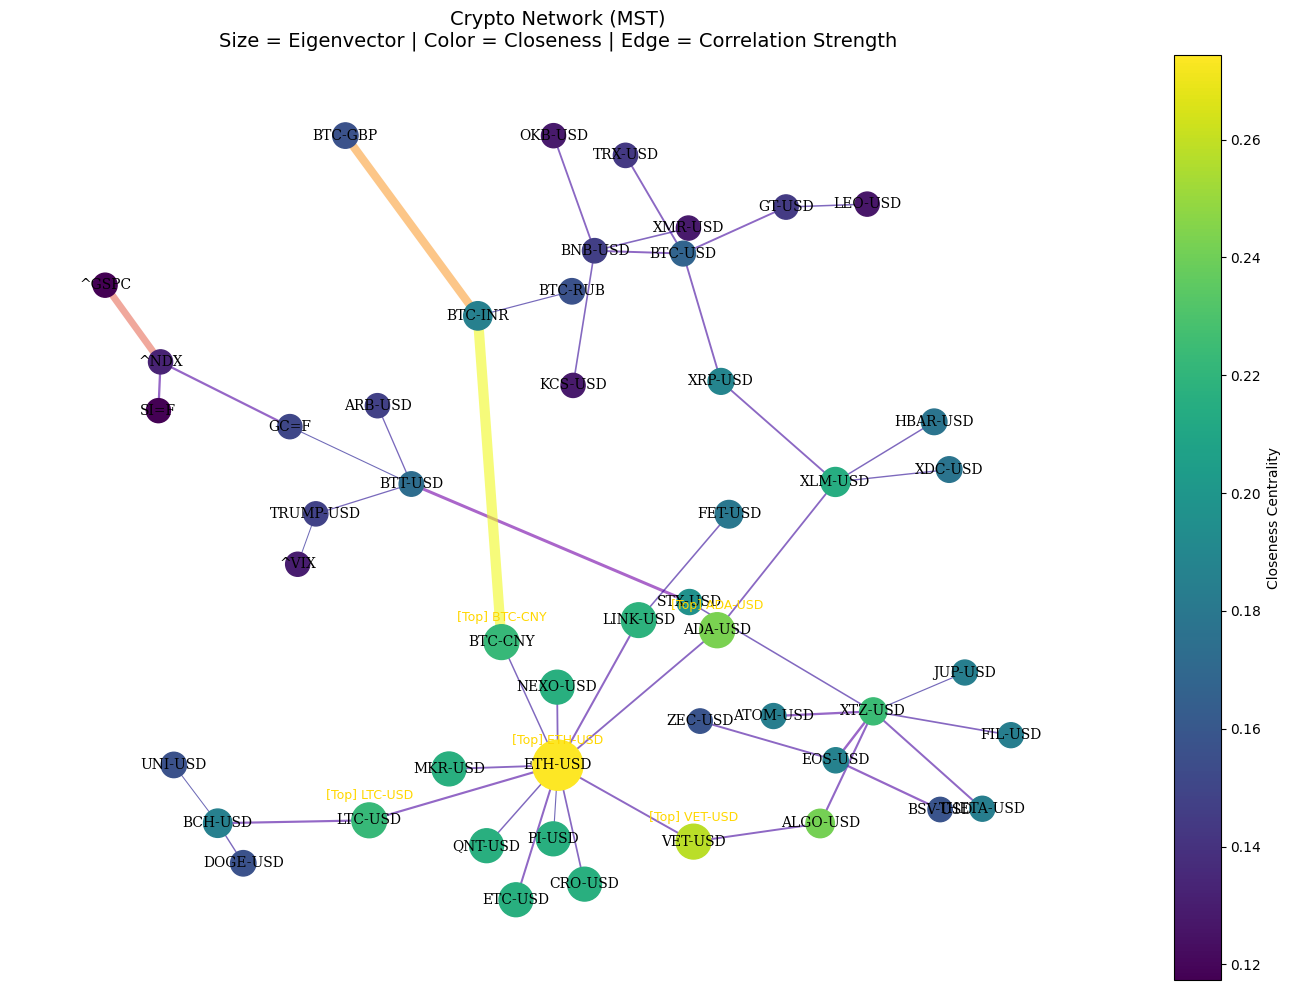

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Use spring layout for positioning
pos = nx.spring_layout(mst, seed=42, k=0.3)

# Centrality scores
eigen = centrality_df['eigenvector']
closeness = centrality_df['closeness']

# Normalize node sizes and colors
node_sizes = 1000 * (eigen - eigen.min()) / (eigen.max() - eigen.min()) + 300
norm_closeness = (closeness - closeness.min()) / (closeness.max() - closeness.min())

# Edge weights and colors based on inverse distance
edge_weights = [1 / mst[u][v]['weight'] for u, v in mst.edges()]
edge_colors = edge_weights

# Set up plot
fig, ax = plt.subplots(figsize=(14, 10))

# Draw nodes
nodes = nx.draw_networkx_nodes(
    mst, pos,
    node_size=node_sizes,
    node_color=norm_closeness,
    cmap=plt.cm.viridis,
    ax=ax
)

# Draw edges with color mapping
edges = nx.draw_networkx_edges(
    mst, pos,
    width=edge_weights,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    edge_vmin=min(edge_colors),
    edge_vmax=max(edge_colors),
    alpha=0.6,
    ax=ax
)

# Draw labels
nx.draw_networkx_labels(
    mst, pos,
    font_size=10,
    font_family='serif',
    ax=ax
)

# Highlight top eigenvector nodes
top_n = eigen.sort_values(ascending=False).head(5).index
for node in top_n:
    x, y = pos[node]
    ax.text(x, y + 0.05, f"[Top] {node}", fontsize=9, ha='center', color='gold')
    #ax.text(x, y + 0.05, f"⭐ {node}", fontsize=9, ha='center', color='gold')

# Add colorbar for node color
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=closeness.min(), vmax=closeness.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Closeness Centrality")

# Final formatting
ax.set_title("Crypto Network (MST)\nSize = Eigenvector | Color = Closeness | Edge = Correlation Strength", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()




In [16]:
filtered_price_df.head()

ticker,ADA-USD,LEO-USD,LTC-USD,MKR-USD,NEXO-USD,OKB-USD,PI-USD,QNT-USD,SI=F,STX-USD,...,DOGE-USD,EOS-USD,ETC-USD,ETH-USD,FET-USD,FIL-USD,GC=F,GT-USD,HBAR-USD,^VIX
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.033458,0.819960,42.017719,437.331451,0.097842,2.621655,0.004066,3.821332,24.315913,0.098774,...,0.002033,2.597236,4.502792,130.802002,0.038509,3.844520,1995.930905,0.353440,0.010439,21.426975
2020-01-02,0.032751,0.821820,39.823013,425.435455,0.105085,2.548617,0.003870,3.534777,17.966000,0.089743,...,0.002009,2.462377,4.255888,127.410179,0.036591,4.459174,1524.500000,0.342423,0.010080,12.470000
2020-01-03,0.034180,0.851479,42.415573,433.531555,0.107530,2.645859,0.003994,3.644010,18.068001,0.094682,...,0.002145,2.637661,4.576237,134.171707,0.039180,3.420579,1549.199951,0.354732,0.010383,14.020000
2020-01-04,0.034595,0.851883,43.326607,440.247009,0.114129,2.662840,0.004095,3.526970,24.315913,0.095139,...,0.002241,2.667841,4.726842,135.069366,0.040505,3.270750,1995.930905,0.357361,0.011203,21.426975
2020-01-05,0.034721,0.856983,43.553207,442.089020,0.116022,2.680283,0.004016,3.584027,24.315913,0.092757,...,0.002419,2.701631,4.907899,136.276779,0.038678,3.496339,1995.930905,0.390090,0.011760,21.426975


In [17]:
from utilities import cluster_from_correlation

data.isna().sum()



date        0
open        0
high        0
low         0
close       0
volume      0
ticker      0
name        0
category    0
market      0
staging     0
dtype: int64

In [18]:
cluster_corr = cluster_from_correlation(data, k=4)
cluster_corr.head()

/usr/local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,ticker,cluster
0,ADA-USD,0
1,ALGO-USD,0
2,ARB-USD,2
3,ATOM-USD,0
4,BCH-USD,0


In [19]:
cluster_corr.head(10)

,ticker,cluster
0,ADA-USD,0
1,ALGO-USD,0
2,ARB-USD,2
3,ATOM-USD,0
4,BCH-USD,0
5,BNB-USD,0
6,BSV-USD,0
7,BTC-CNY,0
8,BTC-GBP,0
9,BTC-INR,0


/tmp/ipykernel_5667/939518759.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cluster_corr, x='cluster', palette='tab10')


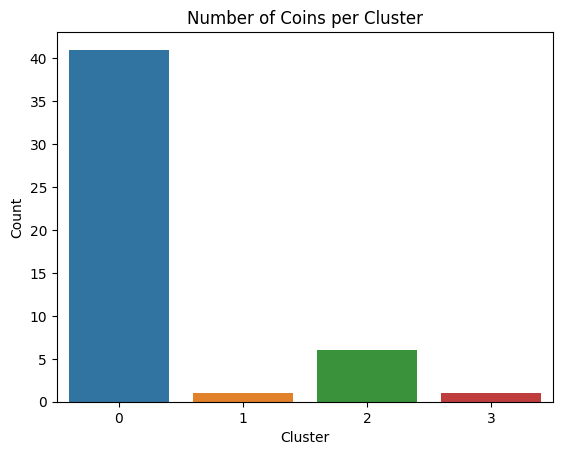

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=cluster_corr, x='cluster', palette='tab10')
plt.title('Number of Coins per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [28]:
cluster_corr[cluster_corr['ticker']=='BTC-USD']

,ticker,cluster
11,BTC-USD,0


In [29]:
cluster_corr[cluster_corr['cluster']>0]

,ticker,cluster
2,ARB-USD,2
20,GC=F,2
23,JUP-USD,3
33,SI=F,2
38,UNI-USD,2
46,^GSPC,2
47,^NDX,2
48,^VIX,1


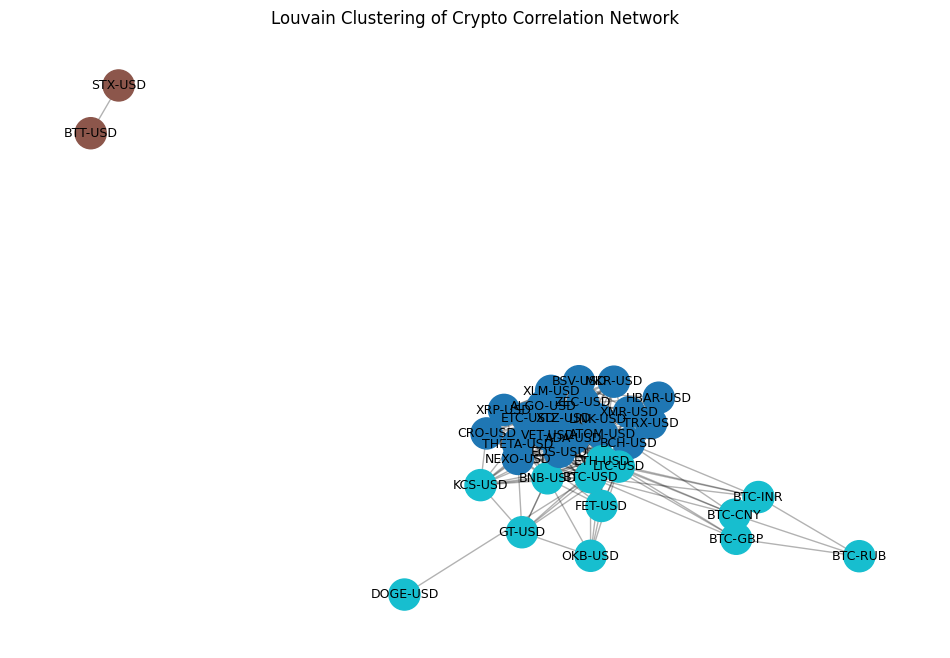

,ticker,cluster
0,ADA-USD,0
1,ALGO-USD,0
2,ATOM-USD,0
3,BCH-USD,0
4,BNB-USD,2


In [32]:
from utilities import louvain_from_returns
cluster_louvain = louvain_from_returns(data, min_corr=0.5, plot=True)


/tmp/ipykernel_5667/2243253579.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cluster_louvain, x='cluster', palette='tab10')


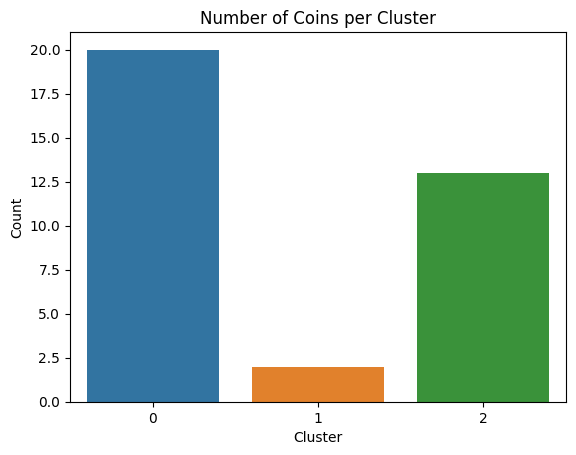

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=cluster_louvain, x='cluster', palette='tab10')
plt.title('Number of Coins per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [57]:
from utilities import technical_analysis

btc_df = data[data['ticker'] == 'BTC-USD'].copy()
btc_df = technical_analysis(btc_df)

Technical Analysis function has been finished


In [60]:
btc_cluster = cluster_louvain[cluster_louvain['ticker'] == 'BTC-USD']['cluster'].values[0]
peer_tickers = cluster_louvain[(cluster_louvain['cluster'] == btc_cluster) & 
                                (cluster_louvain['ticker'] != 'BTC-USD')]['ticker'].tolist()

# Filter and pivot
peer_df = data[data['ticker'].isin(peer_tickers)]
peer_prices = peer_df.pivot(index='date', columns='ticker', values='close').sort_index()


In [61]:
btc_df['return'] = btc_df['close'].pct_change()
btc_df['target'] = (btc_df['return'].shift(-1) > 0).astype(int)  # Predict next-day move


In [62]:
btc_features = btc_df.set_index('date')[[
    'MACD', 'MACD_Diff', 'RSI', 'MFI', 'EMA_Short', 'EMA_Long', 
    'Bollinger_Upper', 'Bollinger_Lower', 'Stochastic', 'SAR', 'target'
]].dropna()

final_df = btc_features.join(peer_prices, how='inner')
final_df = final_df.dropna()  # Drop rows with any missing peer close prices


In [63]:
final_df.head()

,MACD,MACD_Diff,RSI,MFI,EMA_Short,EMA_Long,Bollinger_Upper,Bollinger_Lower,Stochastic,SAR,...,BTC-GBP,BTC-INR,BTC-RUB,DOGE-USD,ETH-USD,FET-USD,GT-USD,KCS-USD,LTC-USD,OKB-USD
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.000000,0.000000,100.000000,50.000000,7200.174316,7200.174316,7200.174316,7200.174316,31.781306,7200.174316,...,7206.696370,7195.344703,7181.218450,0.002033,130.802002,0.038509,0.353440,0.909905,42.017719,2.621655
2020-01-02,-17.127393,-13.701914,0.000000,0.000000,7167.142916,7184.270309,7307.526367,6878.118164,15.733752,6985.470215,...,7040.357592,7017.483130,6974.081449,0.002009,127.410179,0.036591,0.342423,0.863629,39.823013,2.548617
2020-01-03,-1.679899,1.396464,64.320963,58.088046,7194.487741,7196.167640,7472.152410,6881.533462,86.198436,7254.330566,...,7385.429742,7380.469695,7387.826940,0.002145,134.171707,0.039180,0.354732,0.931168,42.415573,2.645859
2020-01-04,15.688789,15.012121,68.334871,69.835729,7227.744510,7212.055721,7561.497911,6909.094862,96.735101,6914.996094,...,7385.429742,7380.469695,7387.826940,0.002241,135.069366,0.040505,0.357361,1.003056,43.326607,2.662840
2020-01-05,29.170646,22.795183,68.373359,76.842751,7255.986490,7226.815844,7594.468668,6946.532504,78.843609,6914.996094,...,7385.429742,7380.469695,7387.826940,0.002419,136.276779,0.038678,0.390090,1.043779,43.553207,2.680283


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Features and target
X = final_df.drop(columns='target')
y = final_df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Pipeline: StandardScaler + RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
print("✅ Model accuracy:", pipeline.score(X_test, y_test))



✅ Model accuracy: 0.5309278350515464


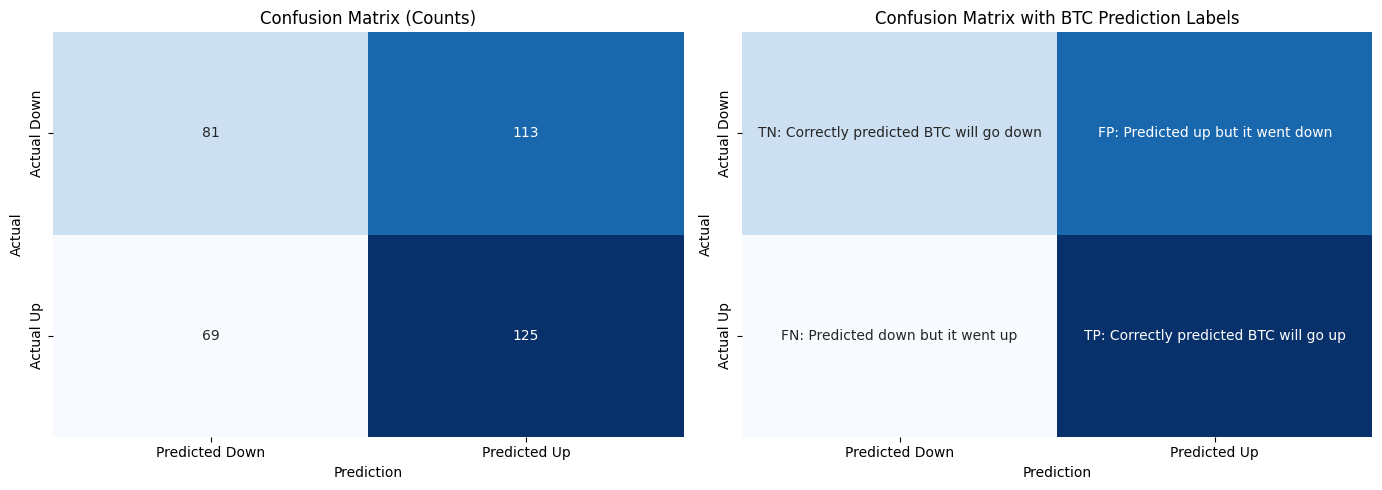

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Labels
labels = np.array([
    ["TN: Correctly predicted BTC will go down", "FP: Predicted up but it went down"],
    ["FN: Predicted down but it went up", "TP: Correctly predicted BTC will go up"]
])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard numerical matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Down", "Predicted Up"],
            yticklabels=["Actual Down", "Actual Up"],
            ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Prediction")
axes[0].set_ylabel("Actual")

# Annotated label version
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=["Predicted Down", "Predicted Up"],
            yticklabels=["Actual Down", "Actual Up"],
            ax=axes[1])
axes[1].set_title("Confusion Matrix with BTC Prediction Labels")
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()




In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))


              precision    recall  f1-score   support

        Down       0.54      0.42      0.47       194
          Up       0.53      0.64      0.58       194

    accuracy                           0.53       388
   macro avg       0.53      0.53      0.52       388
weighted avg       0.53      0.53      0.52       388



In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Prep BTC-only dataframe
btc_lregression = btc_df.copy()
btc_lregression['target'] = btc_lregression['close'].shift(-1)

# Keep only TA indicators + target
btc_features = btc_lregression.set_index('date')[[
    'MACD', 'MACD_Diff', 'RSI', 'MFI', 'EMA_Short', 'EMA_Long',
    'Bollinger_Upper', 'Bollinger_Lower', 'Stochastic', 'SAR', 'target'
]].dropna()

# Join peer prices (cluster tickers)
final_lregression = btc_features.join(peer_prices, how='inner').dropna()

# Features & Target
X = final_lregression.drop(columns='target')
y = final_lregression['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Build pipeline: Standardization + LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
print("✅ R² score:", r2_score(y_test, y_pred))
print("📉 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



✅ R² score: 0.9627305217985713
📉 RMSE: 2971.446254378885


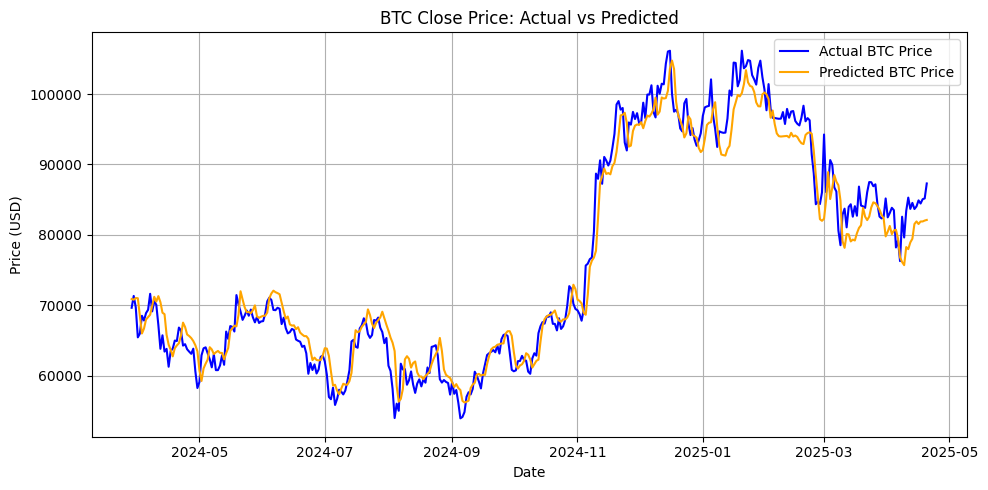

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual BTC Price", color='blue')
plt.plot(y_test.index, y_pred, label="Predicted BTC Price", color='orange')
plt.title("BTC Close Price: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


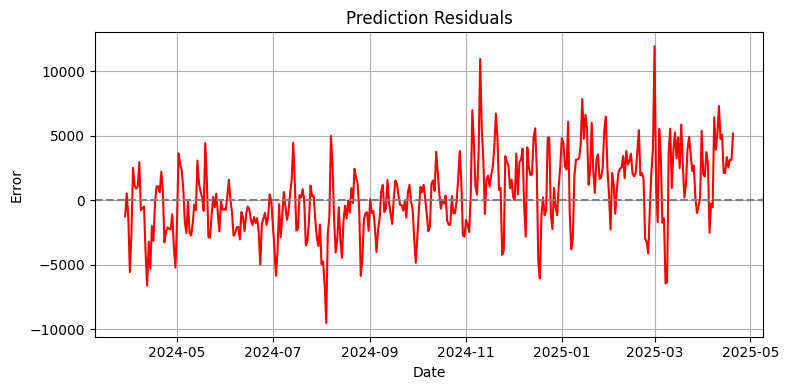

In [90]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.plot(y_test.index, residuals, label='Residuals (Actual - Predicted)', color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Prediction Residuals")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
import statsmodels.api as sm

# Add intercept manually (statsmodels doesn't do it by default)
X_sm = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_sm).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.140e+04
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:13:23   Log-Likelihood:                -17014.
No. Observations:                1937   AIC:                         3.407e+04
Df Residuals:                    1915   BIC:                         3.419e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1343.5799    285.778     

In [92]:
significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()


In [93]:
X_reduced = X[significant_features[1:]]  # skip 'const'

In [97]:
pipeline_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Train using only reduced features
pipeline_reduced.fit(X_train[X_reduced.columns], y_train)

# Predict using reduced feature set on test data
y_pred_reduced = pipeline_reduced.predict(X_test[X_reduced.columns])

# Evaluate
print("✅ R² score (reduced):", r2_score(y_test, y_pred_reduced))
print("📉 RMSE (reduced):", np.sqrt(mean_squared_error(y_test, y_pred_reduced)))




✅ R² score (reduced): 0.9713634194237883
📉 RMSE (reduced): 2604.6645700484837
